In [1]:
import sqlite3
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [2]:
database_name = "habit_tracker.db"


con = sqlite3.connect(database_name)
cur = con.cursor()

cur.execute("""CREATE TABLE IF NOT EXISTS habits(
    id INTEGER PRIMARY KEY,
    name TEXT NOT NULL,
    category TEXT,
    frequency TEXT,
    start_date DATE,
    streak INTEGER,
    longest_streak INTEGER,
    reminder_time TEXT,
    last_update_date DATE
)""")


con.commit()


Welcome to the Habit Tracker CLI!
No habits need updating today.

Main Menu:
1. Add Habit
2. Update Habit
3. Analytics
4. Tutorial
5. Exit
Enter your choice: 3

--- Analytics Overview ---
No habits found or no streaks have been started.
No habits found or no streaks have been recorded.
No habits found to plot.
No habits found.

Main Menu:
1. Add Habit
2. Update Habit
3. Analytics
4. Tutorial
5. Exit
Enter your choice: 4
Welcome to the Habit Tracker Tutorial!

Introduction to the Habit Tracker:
The Habit Tracker is a tool designed to help you build and maintain positive habits. By allowing you to set, track, and analyze your daily and weekly habits, the tracker serves as a personal accountability partner. Whether your goals are related to fitness, learning, mindfulness, or any other area of personal growth, tracking your progress helps increase motivation, reinforces consistency, and provides insightful analytics on your journey towards self-improvement.

In this tutorial, we'll walk yo

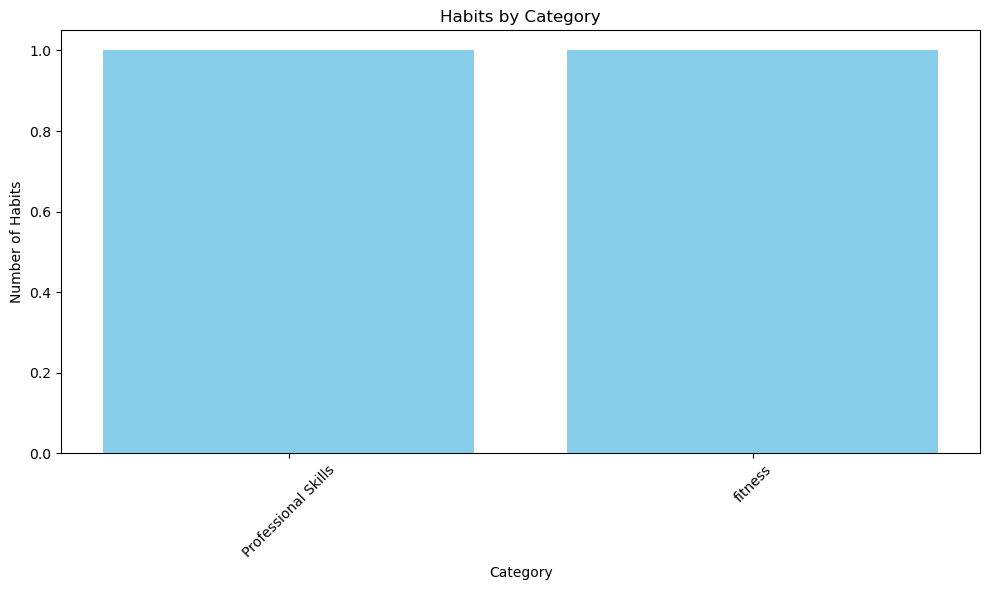

ID  Name                 Category        Frequency  Start Date Streak Longest Streak Reminder Time Last Update Date
---------------------------------------------------------------------------------------------------------
1   morning jog          fitness         daily      2024-03-06 0      0             07:00 am     2024-03-06     
2   Learn Python with IU Professional Skills Weekly     2024-03-06 1      1             07:00 am     2024-03-06     
2 rows deleted successfully.

Main Menu:
1. Add Habit
2. Update Habit
3. Analytics
4. Tutorial
5. Exit
Enter your choice: 3

--- Analytics Overview ---
No habits found or no streaks have been started.
No habits found or no streaks have been recorded.
No habits found to plot.
No habits found.

Main Menu:
1. Add Habit
2. Update Habit
3. Analytics
4. Tutorial
5. Exit


In [ ]:
###### class Habit:
class Habit:
    def __init__(self, database_name):
        self.database_name = database_name
   
    def get_todays_reminders(self):
        # Connect to the database
        con = sqlite3.connect(self.database_name)
        cur = con.cursor()
        
        # Fetch habits that need updating today along with their reminder times
        today_str = datetime.now().date().strftime("%Y-%m-%d")
        cur.execute("SELECT name, reminder_time FROM habits WHERE date(last_update_date) < ? OR last_update_date IS NULL", (today_str,))
        reminders = cur.fetchall()

        con.close()
        return reminders
   
    def add_new_habit(self):
        # Prompt user for habit name
        name = input("Enter the name of your new habit: ")

        # Categories selection
        categories = ['Health', 'Education', 'Fitness', 'Personal Development', 'Professional Skills', 'Hobby']
        print("Select the category of your new habit:")
        for i, category in enumerate(categories, 1):
            print(f"{i}. {category}")
        category_number = self.get_user_selection(len(categories))
        category = categories[category_number - 1]

        # Frequency selection
        frequencies = ['Daily', 'Weekly']
        print("Select the frequency of your new habit:")
        for i, frequency in enumerate(frequencies, 1):
            print(f"{i}. {frequency}")
        frequency_number = self.get_user_selection(len(frequencies))
        frequency = frequencies[frequency_number - 1]

        # Reminder time with validation
        reminder_time = self.get_valid_time("Enter a reminder time for your new habit (HH:MM): ")

        # Other details
        start_date = datetime.now().date()
        streak = 0
        longest_streak = 0
        last_update_date = datetime.now().date()

        # Insert the new habit into the database
        self.insert_habit(name, category, frequency, start_date, streak, longest_streak, reminder_time, last_update_date)

    def get_user_selection(self, options_count):
        while True:
            try:
                selection = int(input("Enter your choice (number): "))
                if 1 <= selection <= options_count:
                    return selection
                else:
                    print(f"Please enter a number between 1 and {options_count}.")
            except ValueError:
                print("Invalid input. Please enter a number.")

    def get_valid_time(self, prompt):
        while True:
            time_str = input(prompt)
            try:
                valid_time = datetime.strptime(time_str, "%H:%M").time()
                return valid_time.strftime("%H:%M")
            except ValueError:
                print("Invalid time format. Please use HH:MM format.")

    def insert_habit(self, name, category, frequency, start_date, streak, longest_streak, reminder_time, last_update_date):
        # Establish connection to the database
        con = sqlite3.connect(self.database_name)
        cur = con.cursor()

        # Insert new habit
        cur.execute("""INSERT INTO habits (name, category, frequency, start_date, streak, longest_streak, reminder_time, last_update_date)
                    VALUES (?, ?, ?, ?, ?, ?, ?, ?)""", 
                    (name, category, frequency, start_date, streak, longest_streak, reminder_time, last_update_date))

        # Commit changes and close connection
        con.commit()
        con.close()
        print(f"New habit '{name}' added successfully.")

    def update_streak(self):
        # Connect to the database
        con = sqlite3.connect(self.database_name)
        cur = con.cursor()

        # Fetch and display all habits with their IDs
        cur.execute("SELECT id, name FROM habits")
        habits = cur.fetchall()

        if not habits:
            print("No habits found.")
            con.close()
            return

        for habit in habits:
            print(f"{habit[0]}. {habit[1]}")
        
        # Ask the user to select a habit to update
        habit_id = input("Enter the number of the habit you want to update: ")
        try:
            habit_id = int(habit_id)
            selected_habit = next((habit for habit in habits if habit[0] == habit_id), None)
            if not selected_habit:
                raise ValueError("Invalid habit selected.")
        except ValueError as e:
            print("Invalid input. Please enter a valid habit number.")
            con.close()
            return
        
        # Get the habit's last update date and current streak
        cur.execute("""SELECT last_update_date, streak, longest_streak FROM habits WHERE id = ?""", (habit_id,))
        habit_data = cur.fetchone()
        
        if habit_data:
            last_update_date, current_streak, longest_streak = habit_data
            last_update_date = datetime.strptime(last_update_date, '%Y-%m-%d').date() if last_update_date else None
            today = datetime.now().date()
            
            # Determine new streak values
            if last_update_date and (today - last_update_date).days == 1:
                new_streak = current_streak + 1
            else:
                new_streak = 1  # Reset streak if more than a day has passed or if never updated

            # Update the longest streak if the new streak is longer
            longest_streak = max(new_streak, longest_streak)
            
            # Update the habit in the database
            cur.execute("""UPDATE habits SET streak = ?, longest_streak = ?, last_update_date = ? WHERE id = ?""",
                        (new_streak, longest_streak, today, habit_id))
            con.commit()
            print(f"Habit '{selected_habit[1]}' updated. New streak: {new_streak}, Longest streak: {longest_streak}.")
        else:
            print("Habit not found.")

        # Close the connection
        con.close()

        
    def print_all_habits(self):
        # Connect to the database
        con = sqlite3.connect(self.database_name)
        cur = con.cursor()

        # Fetch all rows from the habits table
        cur.execute("SELECT * FROM habits")
        habits = cur.fetchall()

        # Check if there are any habits to display
        # Inside the print_all_habits method, modify the loop as follows:

        if habits:
            print(f"{'ID':<3} {'Name':<20} {'Category':<15} {'Frequency':<10} {'Start Date':<10} "
                  f"{'Streak':<6} {'Longest Streak':<13} {'Reminder Time':<12} {'Last Update Date':<15}")
            print("-" * 105)  # Print a divider line
            for habit in habits:
                habit = [str(item) if item is not None else 'N/A' for item in habit]  # Convert None to 'N/A'
                print(f"{habit[0]:<3} {habit[1]:<20} {habit[2]:<15} {habit[3]:<10} {habit[4]:<10} "
                      f"{habit[5]:<6} {habit[6]:<13} {habit[7]:<12} {habit[8]:<15}")
        else:
            print("No habits found.")


        # Close the connection
        con.close()

        
    def get_detailed_current_longest_streak(self):
        with sqlite3.connect(self.database_name) as con:
            cur = con.cursor()
            # Query to find the maximum current streak and the habits that have this streak
            cur.execute("""SELECT name, category, streak FROM habits WHERE streak = (SELECT MAX(streak) FROM habits)""")
            habits_with_max_streak = cur.fetchall()

        if habits_with_max_streak:
            print("Habits with the current longest streak:")
            for habit in habits_with_max_streak:
                print(f"Name: {habit[0]}, Category: {habit[1]}, Current Streak: {habit[2]}")
        else:
            print("No habits found or no streaks have been started.")

    def get_detailed_historical_longest_streak(self):
        with sqlite3.connect(self.database_name) as con:
            cur = con.cursor()
            # Query to find the maximum historical longest streak and the habits that have this streak
            cur.execute("""SELECT name, category, longest_streak FROM habits WHERE longest_streak = (SELECT MAX(longest_streak) FROM habits)""")
            habits_with_max_longest_streak = cur.fetchall()

        if habits_with_max_longest_streak:
            print("Habits with the historical longest streak:")
            for habit in habits_with_max_longest_streak:
                print(f"Name: {habit[0]}, Category: {habit[1]}, Longest Streak: {habit[2]}")
        else:
            print("No habits found or no streaks have been recorded.")
            
    def plot_habits_by_category(self):
        # Connect to the database
        con = sqlite3.connect(self.database_name)
        cur = con.cursor()

        # Fetch categories and counts of all habits
        cur.execute("SELECT category, COUNT(*) FROM habits GROUP BY category")
        habits_data = cur.fetchall()

        # Close the connection
        con.close()

        if habits_data:
            # Unpack the data into two lists for plotting
            categories, counts = zip(*habits_data)

            # Create a bar graph
            plt.figure(figsize=(10, 6))
            plt.bar(categories, counts, color='skyblue')
            plt.xlabel('Category')
            plt.ylabel('Number of Habits')
            plt.title('Habits by Category')
            plt.xticks(rotation=45)
            plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
            
            # Show the plot
            plt.show()
        else:
            print("No habits found to plot.")
            
    def show_analytics(self):
        print("\n--- Analytics Overview ---")
        self.get_detailed_current_longest_streak()
        self.get_detailed_historical_longest_streak()
        self.plot_habits_by_category()
        self.print_all_habits()  
 
    def tutorial(self):
        print("Welcome to the Habit Tracker Tutorial!\n")
        
        # Introduction to the Habit Tracker
        print("Introduction to the Habit Tracker:")
        print("The Habit Tracker is a tool designed to help you build and maintain positive habits. "
              "By allowing you to set, track, and analyze your daily and weekly habits, "
              "the tracker serves as a personal accountability partner. Whether your goals "
              "are related to fitness, learning, mindfulness, or any other area of personal growth, "
              "tracking your progress helps increase motivation, reinforces consistency, and "
              "provides insightful analytics on your journey towards self-improvement.\n")
        
        print("In this tutorial, we'll walk you through the key features of the Habit Tracker, including:")
        print("- How to add new habits.")
        print("- How to update your habit progress.")
        print("- Viewing analytics to understand your habit patterns.")
        print("- And more tips to get the most out of your habit tracking experience.\n")

        print("\nAdding a New Habit:")
        print("Let's walk through the process of adding a new habit to your tracker. "
              "For this example, we'll add a habit called 'Morning Jog', categorized under 'Fitness', "
              "that you plan to do daily at 07:00 AM.\n")
        
        # Walk the user through creating the 'Morning Jog' habit
        name = self.prompt_user_input("Enter the name of your new habit (example: Morning Jog): ", "Morning Jog")
        category = self.prompt_user_input("Enter the category of your new habit (example: Fitness): ", "Fitness")
        frequency = self.prompt_user_input("Enter the frequency of your new habit (example: Daily): ", "Daily")
        reminder_time = self.prompt_user_input("Enter a reminder time for your new habit (example: 07:00 AM): ", "07:00 AM")

        #Add the user input to the database as well as a second example 
        self.insert_habit(name, category, frequency, datetime.now().date(), 0, 0, reminder_time, datetime.now().date())
        self.insert_habit("Learn Python with IU", "Professional Skills", "Weekly", datetime.now().date(), 0, 0, reminder_time, datetime.now().date())
            
        # After collecting inputs, insert the habit into the database (assuming implementation exists)
        print(f"\nGreat! You've just added the following habit to your tracker:")
        print(f"Name: {name}, Category: {category}, Frequency: {frequency}, Reminder Time: {reminder_time}\n")
        print("I've also added an additional habit to showcase the analytics with the following details:")
        print("Name: Learn Pythong with IU, Category: Personal Development, Frequency: Weekly, Streak:0")
        print("Now let's move on to updating your habit progress and exploring analytics...")

        print("\nUpdating a Habit:")
        print("Now that you've added your a habit, let's simulate marking it as completed for today.")
        print("[1] Morning Jog")
        print("[2] Learn Python with IU")
        
        user_input = input("When updating a habit, you will see the list of habits (like above) for your selection, in this example, type '2'")
        while user_input != "2":
            print("When updating a habit, you will see the list of habits for your selection, in this example, type '2'")
            user_input = input("Please type in '2' and press Enter: ")

        con = sqlite3.connect(database_name)
        cur = con.cursor()
        update_sql = """
        UPDATE habits
        SET streak = 1, longest_streak = 1, last_update_date = ?
        WHERE name = 'Learn Python with IU'
        """
        cur.execute(update_sql, (datetime.now().date(),))

        # Commit the changes to the database
        con.commit()
        if cur.rowcount == 1:
            print("Habit 'Learn Python with IU' updated successfully.")
        else:
            print("Habit 'Learn Python with IU' not found.")

        # Close the database connection
        con.close()      
        
        print("Finally, the Analytics function will give you details to help you succeed")
        print("It will tell you the currect highest streak, the longest historical streak, a graphical view of habits by category as well as all details of all habits")
        print("The tutorial will end now, thank you for taking it. Come back any time if there is still something you want to learn. Below are you analytics")
        self.show_analytics()
        
        con = sqlite3.connect(database_name)
        cur = con.cursor()

        # SQL to delete the bottom two rows based on the highest IDs
        delete_sql = """
        DELETE FROM habits
        WHERE id IN (
            SELECT id FROM habits
            ORDER BY id DESC
            LIMIT 2
        )
        """

        # Execute the delete command
        cur.execute(delete_sql)

        # Commit the changes to the database
        con.commit()

        # Check if the delete was successful
        if cur.rowcount >= 1:
            print(f"{cur.rowcount} rows deleted successfully.")
        else:
            print("No rows deleted. The table might be empty or have less than two rows.")

        # Close the database connection
        con.close()
        
    def prompt_user_input(self, prompt_text, expected_answer):
        user_input = input(prompt_text)
        while user_input.lower() != expected_answer.lower():
            print(f"Oops! It looks like you entered '{user_input}' which doesn't match the expected '{expected_answer}'. Let's try that again.")
            user_input = input(prompt_text)
        return user_input
    
    def show_menu(self):
        print("\nMain Menu:")
        print("1. Add Habit")
        print("2. Update Habit")
        print("3. Analytics")
        print("4. Tutorial")
        print("5. Exit")
        
def main():
    database_name = "habit_tracker.db"
    habit_tracker = Habit(database_name)

    print("Welcome to the Habit Tracker CLI!")
    # Show today's reminders
    reminders = habit_tracker.get_todays_reminders()
    if reminders:
        print("\nHabits to update today:")
        for name, time in reminders:
            print(f"- {name} (Reminder set for {time})")
    else:
        print("No habits need updating today.")

    while True:
        habit_tracker.show_menu()
        choice = input("Enter your choice: ")
        
        if choice == "1":
            habit_tracker.add_new_habit()
        elif choice == "2":
            habit_tracker.update_streak()
        elif choice == "3":
            habit_tracker.show_analytics()
        elif choice == "4":
            habit_tracker.tutorial()
        elif choice == "5":
            print("Exiting the Habit Tracker CLI. Have a great day!")
            break
        else:
            print("Invalid choice, please select a valid option.")

if __name__ == "__main__":
    main()

# Usage
database_name = "habit_tracker.db"
habit_tracker = Habit(database_name)

In [ ]:
4


In [ ]:
table_name = "habits"  # Adjust if your table name is different

# Connect to the SQLite database
con = sqlite3.connect(database_name)
cur = con.cursor()

# SQL to delete all contents of the table
delete_sql = f"DELETE FROM {table_name}"

# Execute the delete command
cur.execute(delete_sql)

# Commit the changes to the database
con.commit()

print("All contents of the table have been deleted successfully.")

# Close the database connection
con.close()